In [1]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import os
import json
import random
from tqdm import tqdm

In [2]:
# Configure compute device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✓ Using device: {device}")
torch.cuda.empty_cache()
if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

✓ Using device: cuda
  GPU: NVIDIA A100-SXM4-40GB
  Memory: 42.29 GB


In [3]:
# Load model directly
from transformers import AutoImageProcessor, AutoModel, AutoModelForImageClassification
from huggingface_hub import hf_hub_download

/opt/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Load the pre-trained model and processor
processor = AutoImageProcessor.from_pretrained('facebook/dinov2-small')
model = AutoModel.from_pretrained('facebook/dinov2-small')
model = model.to(device)

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: e9a36a3a-9320-4922-abd3-a929ba0d66e6)')' thrown while requesting HEAD https://huggingface.co/api/resolve-cache/models/facebook/dinov2-small/ed25f3a31f01632728cabb09d1542f84ab7b0056/config.json
Retrying in 1s [Retry 1/5].


In [5]:
def load_images_with_labels(root_dir):
    images = []
    labels = []
    classes = sorted(os.listdir(root_dir)) 
    for label_idx, class_name in enumerate(classes):
        class_dir = os.path.join(root_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                img_path = os.path.join(class_dir, filename)
                try:
                    img = Image.open(img_path).convert("RGB")
                    images.append(img)
                    labels.append(label_idx)
                except Exception as e:
                    print(f"Image load failed: {img_path} ({e})")
    return images, labels, classes

In [6]:
train_img_path = '/workspace/image-finetuners/data/train'
test_img_path = '/workspace/image-finetuners/data/validation'

train_images, train_labels, class_names = load_images_with_labels(train_img_path)
print("Class names:", class_names)
print("Total number of images:", len(train_images))

# image processing
inputs = processor(images=train_images, return_tensors="pt")
pixel_values = inputs.pixel_values.to(device)
labels = torch.tensor(train_labels).to(device)

print(pixel_values.shape)
print(labels.shape)

Class names: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Total number of images: 28821
torch.Size([28821, 3, 224, 224])
torch.Size([28821])


In [6]:
class EmotionDataset(Dataset):
    def __init__(self, data_dir, processor):

        self.data_dir = data_dir
        self.processor = processor
        self.samples = []   # (img_path, label)
        self.classes = sorted(os.listdir(data_dir))

        for label_idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(data_dir, class_name)
            if not os.path.isdir(class_dir):
                continue
            for filename in os.listdir(class_dir):
                if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                    img_path = os.path.join(class_dir, filename)
                    self.samples.append((img_path, label_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")

        inputs = self.processor(images=image, return_tensors="pt")

        pixel_values = inputs["pixel_values"].squeeze(0)

        return pixel_values, label


In [13]:
train_img_path = '/workspace/image-finetuners/data/train'
test_img_path = '/workspace/image-finetuners/data/validation'

train_dataset = EmotionDataset(train_img_path, processor)
test_dataset = EmotionDataset(test_img_path, processor)

batch_size = 64
# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Classes: {train_dataset.classes}")

Train samples: 28821
Test samples: 7066
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [22]:
pixel_values, labels = next(iter(train_loader))
print(pixel_values.shape)  # [batch, 3, 224, 224]
print(labels.shape)        # [batch]

torch.Size([32, 3, 224, 224])
torch.Size([32])


# Fine-tuning

In [8]:
num_classes = 7

class DinoClassifier(nn.Module):
    def __init__(self, backbone, num_classes):
        super().__init__()
        self.backbone = backbone
        hidden_dim = backbone.config.hidden_size  # e.g. 768
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, pixel_values):
        # DINOv2 feature extraction
        outputs = self.backbone(pixel_values=pixel_values)
        features = outputs.pooler_output
        logits = self.classifier(features)
        return logits


In [12]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

In [14]:
model_backbone = 
model_ft = DinoClassifier(model, num_classes=7)
model_ft = model_ft.to(device)
model_ft.train()
for epoch in range(20):
    total_loss = 0
    for pixel_values, labels in tqdm(train_loader):
        pixel_values = pixel_values.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model_ft(pixel_values)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}: loss = {avg_loss:.4f}")


100%|██████████| 451/451 [00:44<00:00, 10.16it/s]


Epoch 1: loss = 1.7428


100%|██████████| 451/451 [00:45<00:00,  9.94it/s]


Epoch 2: loss = 1.6933


100%|██████████| 451/451 [00:45<00:00,  9.88it/s]


Epoch 3: loss = 1.6593


100%|██████████| 451/451 [00:45<00:00,  9.93it/s]


Epoch 4: loss = 1.6128


100%|██████████| 451/451 [00:45<00:00,  9.96it/s]


Epoch 5: loss = 1.5692


100%|██████████| 451/451 [00:45<00:00,  9.97it/s]


Epoch 6: loss = 1.5223


100%|██████████| 451/451 [00:45<00:00,  9.93it/s]


Epoch 7: loss = 1.4837


100%|██████████| 451/451 [00:45<00:00,  9.91it/s]


Epoch 8: loss = 1.4390


100%|██████████| 451/451 [00:45<00:00,  9.95it/s]


Epoch 9: loss = 1.3934


100%|██████████| 451/451 [00:45<00:00,  9.93it/s]


Epoch 10: loss = 1.3541


100%|██████████| 451/451 [00:45<00:00,  9.93it/s]


Epoch 11: loss = 1.3239


100%|██████████| 451/451 [00:45<00:00,  9.92it/s]


Epoch 12: loss = 1.2839


100%|██████████| 451/451 [00:45<00:00,  9.92it/s]


Epoch 13: loss = 1.2441


100%|██████████| 451/451 [00:45<00:00,  9.92it/s]


Epoch 14: loss = 1.2038


100%|██████████| 451/451 [00:45<00:00,  9.93it/s]


Epoch 15: loss = 1.1566


100%|██████████| 451/451 [00:45<00:00,  9.96it/s]


Epoch 16: loss = 1.1040


100%|██████████| 451/451 [00:45<00:00,  9.92it/s]


Epoch 17: loss = 1.0522


100%|██████████| 451/451 [00:45<00:00,  9.92it/s]


Epoch 18: loss = 0.9940


100%|██████████| 451/451 [00:45<00:00,  9.94it/s]


Epoch 19: loss = 0.9388


100%|██████████| 451/451 [00:45<00:00,  9.94it/s]

Epoch 20: loss = 0.8802


In [15]:
model_ft.eval()
correct = 0
total = 0

with torch.no_grad():
    for pixel_values, labels in test_loader:
        pixel_values = pixel_values.to(device)
        labels = labels.to(device)

        logits = model_ft(pixel_values)
        preds = torch.argmax(logits, dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

acc = correct / total
print(f"Test Accuracy: {acc:.4f}")

Test Accuracy: 0.4690


In [17]:
model_ft.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for pixel_values, labels in test_loader:
        pixel_values = pixel_values.to(device)
        labels = labels.to(device)

        logits = model_ft(pixel_values)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

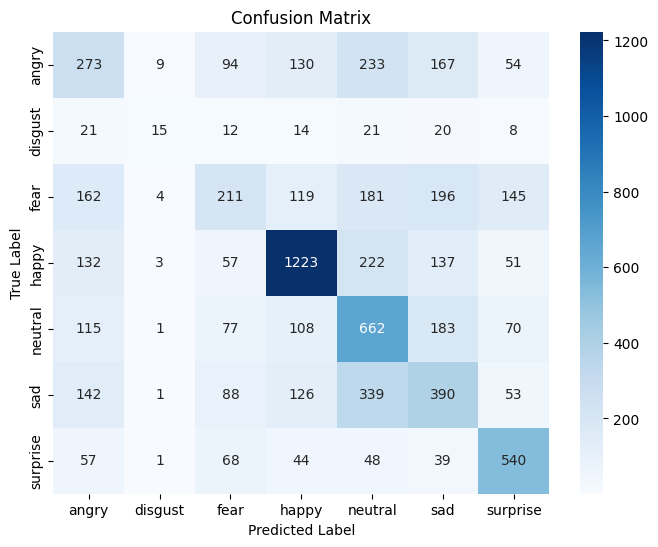

In [19]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
cm = confusion_matrix(all_labels, all_preds)
class_names = test_dataset.classes

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [20]:
plt.savefig('confusion_mat.png', dpi=300)

<Figure size 640x480 with 0 Axes>

In [21]:
for epoch in range(10):
    total_loss = 0
    for pixel_values, labels in tqdm(train_loader):
        pixel_values = pixel_values.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model_ft(pixel_values)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}: loss = {avg_loss:.4f}")

100%|██████████| 451/451 [00:43<00:00, 10.25it/s]


Epoch 1: loss = 0.7895


100%|██████████| 451/451 [00:45<00:00,  9.99it/s]


Epoch 2: loss = 0.7152


100%|██████████| 451/451 [00:45<00:00, 10.01it/s]


Epoch 3: loss = 0.6449


100%|██████████| 451/451 [00:45<00:00, 10.00it/s]


Epoch 4: loss = 0.5779


100%|██████████| 451/451 [00:45<00:00,  9.96it/s]


Epoch 5: loss = 0.5140


100%|██████████| 451/451 [00:45<00:00,  9.94it/s]


Epoch 6: loss = 0.4555


100%|██████████| 451/451 [00:45<00:00,  9.91it/s]


Epoch 7: loss = 0.3920


100%|██████████| 451/451 [00:45<00:00,  9.98it/s]


Epoch 8: loss = 0.3397


100%|██████████| 451/451 [00:45<00:00,  9.94it/s]


Epoch 9: loss = 0.3055


100%|██████████| 451/451 [00:45<00:00,  9.98it/s]

Epoch 10: loss = 0.2599


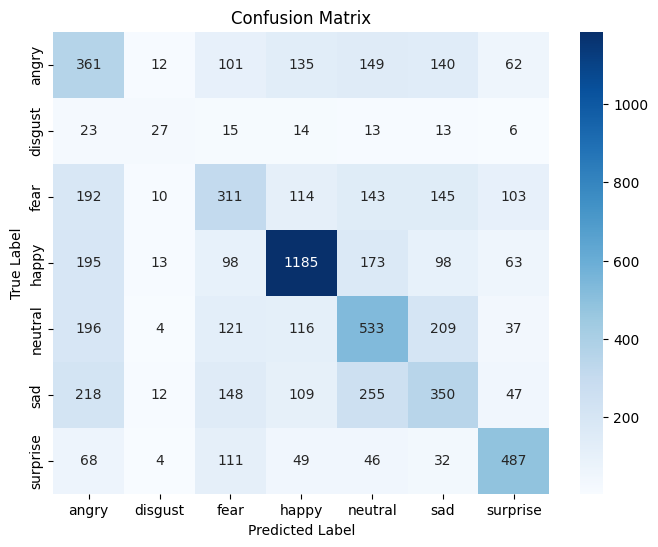

In [22]:
model_ft.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for pixel_values, labels in test_loader:
        pixel_values = pixel_values.to(device)
        labels = labels.to(device)

        logits = model_ft(pixel_values)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

cm = confusion_matrix(all_labels, all_preds)
class_names = test_dataset.classes

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [23]:
model_ft.eval()
correct = 0
total = 0

with torch.no_grad():
    for pixel_values, labels in test_loader:
        pixel_values = pixel_values.to(device)
        labels = labels.to(device)

        logits = model_ft(pixel_values)
        preds = torch.argmax(logits, dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

acc = correct / total
print(f"Test Accuracy: {acc:.4f}")

Test Accuracy: 0.4605
